# MARL MIDSEM


#### MANISH GAYEN,  Roll: 21161



In [54]:
"""Environment for Modified Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def main() -> None:
    """Main function."""
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # You need to replace this with your algorithm that predicts the action.

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

    print(np.mean(ep_rets))



Episode 1/1000, Reward: -79977.52570343018
Episode 2/1000, Reward: -79927.52570343018
Episode 3/1000, Reward: -79907.52570343018
Episode 4/1000, Reward: -69915.94783973694
Episode 5/1000, Reward: -69825.92739868164
Episode 6/1000, Reward: -79957.52570343018
Episode 7/1000, Reward: -69895.94783782959
Episode 8/1000, Reward: -69895.94783782959
Episode 9/1000, Reward: -59835.12351226807
Episode 10/1000, Reward: -59835.12351226807
Episode 11/1000, Reward: -79907.52570343018
Episode 12/1000, Reward: -69875.94783973694
Episode 13/1000, Reward: -69875.94783973694
Episode 14/1000, Reward: -59865.123514175415
Episode 15/1000, Reward: -59865.123514175415
Episode 16/1000, Reward: -59865.123514175415
Episode 17/1000, Reward: -49832.782876968384
Episode 18/1000, Reward: -49832.782876968384
Episode 19/1000, Reward: -49832.782876968384
Episode 20/1000, Reward: -49832.782876968384
Episode 21/1000, Reward: -39789.99495124817
Episode 22/1000, Reward: -39789.99495124817
Episode 23/1000, Reward: -39789.99

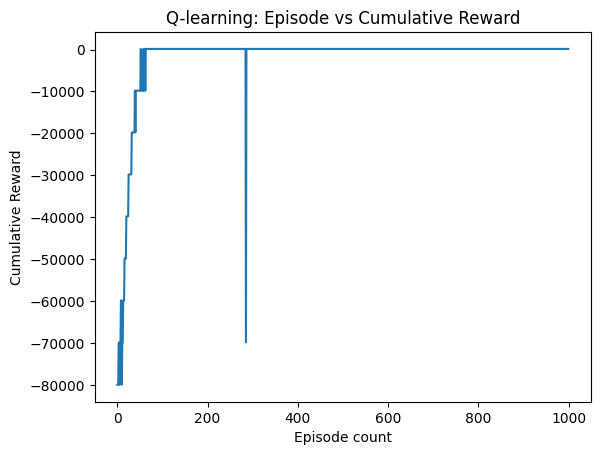

In [57]:
##solution

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym

# q learning
class QLearningAgent:
    def __init__(self, num_actions, alpha=0.009, gamma=0.05, epsilon=0.0001):               #parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # Exploration-exploitation balance
        self.num_actions = num_actions
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions))  # initialize q-table
    
    def select_action(self, state):
        
        #selects an action using epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit
    
    def update(self, state, action, reward, next_state, done):
        #update q value

        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action] * (not done)
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_delta

# training Q-learning on environment
def train_q_learning(env, num_episodes=1000, shuffle_interval=10):
    agent = QLearningAgent(num_actions=env.num_targets)
    episode_rewards = []
    
    for ep in range(num_episodes):
        state, _ = env.reset()
        state = tuple(state) 
        
        total_reward = 0
        done = False
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = tuple(next_state)
            
            done = terminated or truncated
            agent.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
        
        episode_rewards.append(total_reward)
        print(f"Episode {ep + 1}/{num_episodes}, Reward: {total_reward}")
    
    return episode_rewards

# plotting
def plot_rewards(episode_rewards):
    plt.plot(episode_rewards)
    plt.xlabel("Episode count")
    plt.ylabel("Cumulative Reward")
    plt.title("Q-learning: Episode vs Cumulative Reward")
    plt.show()



# main function
def main():
    num_targets = 10
    env = ModTSP(num_targets=num_targets)
    
    # train agent
    num_episodes = 1000 
    rewards = train_q_learning(env, num_episodes=num_episodes)

    pos_reward = 0
    for reward in rewards:
        if reward>0:
            pos_reward+=1
    print("positive rewards count: ", pos_reward)
    #print("\n")
    print("highest cumulative reward achieved:", str(max(rewards)))
    print("average cumulative rewards value:", (sum(rewards))/len(rewards))     #high because the negatives are very high at the inittial stage
    #print("\n")

    # Plot the results
    plot_rewards(rewards)

if __name__ == "__main__":
    main()